### 📘 Financial Analysis Portfolio

**Author:** Rui Carvalho Caseiro     
**LinkedIn:** [https://www.linkedin.com/in/ruicarvalhocaseiro/](https://www.linkedin.com/in/ruicarvalhocaseiro/)  
**GitHub:** [https://github.com/notp1ssed](https://github.com/notp1ssed)  
**Email:** ruicarvalhocaseiro@outlook.pt

*Exploring financial data, building models, and testing strategies through Python and data science.*

# Imports

In [26]:
import pandas as pd
import numpy as np
import quantstats as qs
import pandas_ta as ta

import statsmodels.api as sm

import MyCustomLibrary.backtester_tools as tools
from MyCustomLibrary.features import get_ROC_vola_adj
from MyCustomLibrary.atw import timer, train_test_split

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format

## Data

In [27]:
quotes = pd.read_csv(
    r'D:\OneDrive - Instituto Politecnico de Castelo Branco\002_Learning\000_Local_Pyhton_Packages\MyDataLibrary\bitcoin_full.csv',
    index_col=[0], parse_dates=True)

quotes

,Open,High,Low,Close
Date,,,,
2010-07-17,0.05,0.05,0.05,0.05
2010-07-18,0.05,0.09,0.05,0.09
2010-07-19,0.09,0.09,0.08,0.08
2010-07-20,0.08,0.08,0.07,0.07
2010-07-21,0.07,0.08,0.07,0.08
...,...,...,...,...
2025-04-04,83100.25,84696.15,81670.75,83843.80
2025-04-05,83844.70,84207.02,82377.73,83504.80
2025-04-06,83504.51,83704.72,77097.74,78214.48


In [28]:
quotes.shape

(5374, 4)

In [29]:
quotes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5374 entries, 2010-07-17 to 2025-04-08
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5374 non-null   float64
 1   High    5374 non-null   float64
 2   Low     5374 non-null   float64
 3   Close   5374 non-null   float64
dtypes: float64(4)
memory usage: 209.9 KB


In [30]:
quotes.dtypes

Open     float64
High     float64
Low      float64
Close    float64
dtype: object

In [31]:
quotes.describe()

,Open,High,Low,Close
count,5374.00,5374.00,5374.00,5374.00
mean,15414.78,15757.01,15051.96,15428.12
std,23001.80,23490.92,22477.17,23014.44
min,0.05,0.05,0.01,0.05
25%,239.00,244.11,236.04,239.32
50%,3967.70,4069.98,3890.57,3974.20
75%,23067.84,23454.45,22683.41,23108.08
max,106147.30,109114.88,105291.73,106146.27


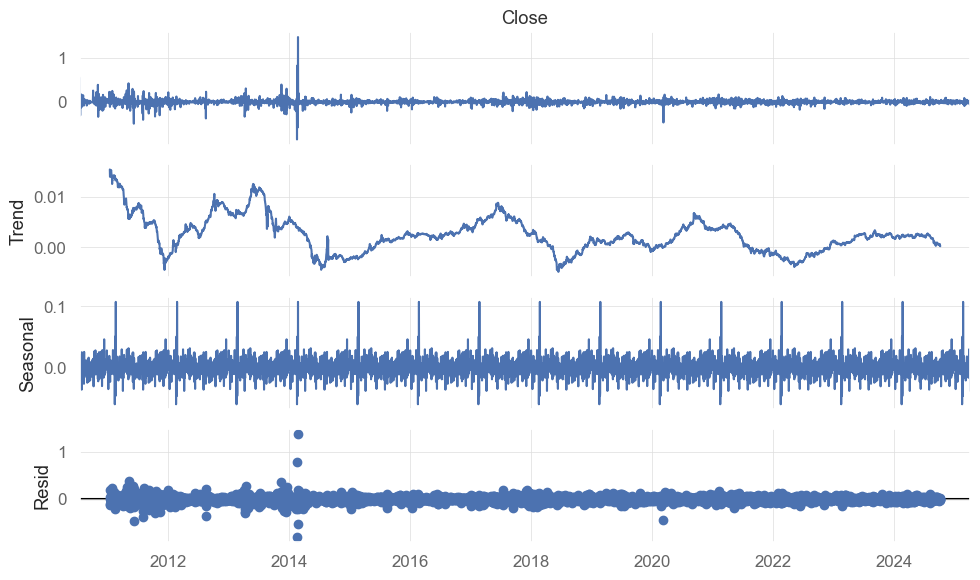

In [32]:
n = 1
y = np.log(quotes['Close']/quotes['Close'].shift(n)).shift(-n).dropna()
plot = sm.tsa.seasonal_decompose(y,period=int(365/n))
plot.plot();

#### Features Engineering

In [33]:
def df_add_alpha_factors(quotes_df: pd.DataFrame) -> pd.DataFrame:
    ''' 
        Input: Feed a SINGLE Level DataFrame with several assets prices
        Output: Get the same Data Frame plus Several indicators for each symbol
    '''
    all_new_columns = []

    close_series = quotes_df['Close']
    high_series = quotes_df['High']
    low_series = quotes_df['Low']

    new_columns = {}

    for lenght in [20, 50, 100]:
        new_columns[f'MA{lenght}'] = close_series.rolling(window=lenght, min_periods=lenght).mean()
        new_columns[f'EMA{lenght}'] = close_series.ewm(span=lenght, min_periods=lenght, adjust=False).mean()
        new_columns[f'RollMax{lenght}'] = high_series.rolling(lenght).max()
        new_columns[f'RollMin{lenght}'] = low_series.rolling(lenght).min()
        
        new_columns[f'ATR{lenght}'] = ta.atr(high=high_series, low=low_series, close=close_series, length=lenght)

    
    for lenght in [10, 30, 200]:
        new_columns[f'ROC{lenght}'] = get_ROC_vola_adj(close_series, lenght)
        new_columns[f'MOM{lenght}'] = close_series.diff(lenght)
        
        new_columns[f'RSI{lenght}'] = ta.rsi(close_series, length=lenght)
        new_columns[f'STOK{lenght}'] = ta.stoch(high=quotes['High'], low=quotes['Low'], close=quotes['Close'], k=lenght).iloc[:,0]
        new_columns[f'STOD{lenght}'] = ta.stoch(high=quotes['High'], low=quotes['Low'], close=quotes['Close'], k=lenght).iloc[:,1]
        new_columns[f'ADX{lenght}'] = ta.adx(high=high_series, low=low_series, close=close_series, length=lenght).iloc[:,0]
        

    # Convert the dictionary to a DataFrame with MultiIndex columns
    symbol_df = pd.DataFrame(new_columns)
    all_new_columns.append(symbol_df)

    # Concatenate all new columns horizontally
    result_df = pd.concat([quotes_df] + all_new_columns, axis=1)
        
    return result_df

df = df_add_alpha_factors(quotes)

#### Preparation for Classification

In [16]:
df['signal'] =  np.where(df['EMA20'] > df['MA100'], 1.0, 0.0)
df

,Open,High,Low,Close,MA20,EMA20,RollMax20,RollMin20,ATR20,MA50,...,STOK30,STOD30,ADX30,ROC200,MOM200,RSI200,STOK200,STOD200,ADX200,signal
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-17,0.05,0.05,0.05,0.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2010-07-18,0.05,0.09,0.05,0.09,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2010-07-19,0.09,0.09,0.08,0.08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2010-07-20,0.08,0.08,0.07,0.07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
2010-07-21,0.07,0.08,0.07,0.08,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-04,83100.25,84696.15,81670.75,83843.80,84490.48,84501.16,88758.73,81179.99,3499.28,87441.19,...,40.29,40.17,22.95,16.26,25651.30,51.46,49.64,50.12,7.21,0.00
2025-04-05,83844.70,84207.02,82377.73,83504.80,84536.74,84406.27,88758.73,81179.99,3415.78,87161.11,...,43.96,41.89,22.56,14.26,23196.26,51.40,49.84,50.01,7.19,0.00
2025-04-06,83504.51,83704.72,77097.74,78214.48,84243.68,83816.57,88758.73,77097.74,3575.34,86773.79,...,34.99,39.75,22.52,9.74,16564.80,50.48,46.13,48.54,7.19,0.00


<Axes: ylabel='signal'>

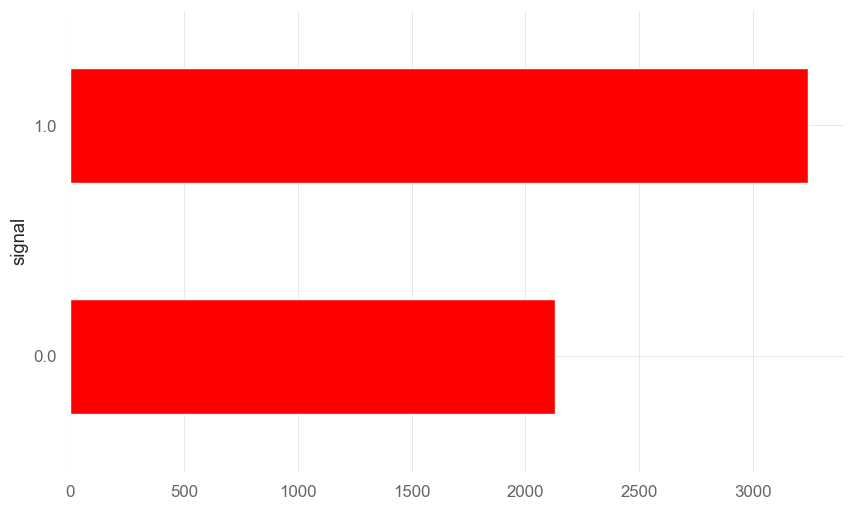

In [17]:
df.groupby(['signal']).size().plot(kind='barh', color='red')

### ML model preparation

    y is the variable we want to predict
    X are the variables that may help to predict y

In [18]:
X = df.drop(columns= ['signal', 'Open', 'High', 'Low'])
y = df["signal"]

X_train, X_test = train_test_split(X)
y_train, y_test = train_test_split(y)

In [19]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [20]:
y_pred = model.predict(X_test)

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score

print('MAE:', mean_absolute_error(y_pred, y_test))
print('MSE:', mean_squared_error(y_pred, y_test))
print('R2:', r2_score(y_pred, y_test))
print('Accuracy Score:', accuracy_score(y_pred, y_test))

MAE: 0.10604651162790697
MSE: 0.10604651162790697
R2: 0.5271078525950222
Accuracy Score: 0.893953488372093


In [22]:
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

<Axes: >

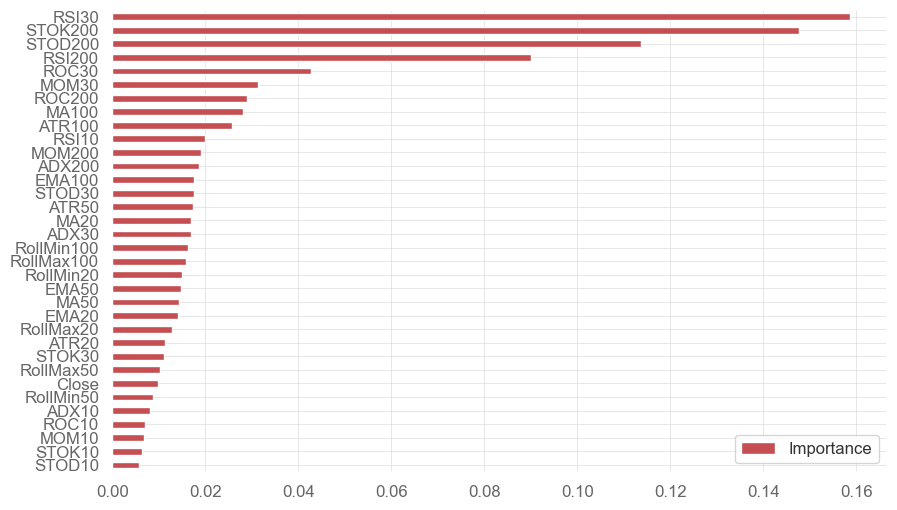

In [23]:
features_importance = pd.DataFrame({'Importance':model.feature_importances_},index=X.columns)
features_importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r')

#### Backtest Signals

In [24]:
backtestdata = pd.DataFrame(index=X_test.index)

backtestdata['signal_actual'] = y_test
backtestdata['signal_pred'] = y_pred

backtestdata['Market Returns'] = np.log(X_test['Close']/X_test['Close'].shift(1))
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)

backtestdata=backtestdata.reset_index()
backtestdata.head()

,Date,signal_actual,signal_pred,Market Returns,Actual Returns,Strategy Returns
0,2022-04-30,0.00,0.00,NaN,NaN,NaN
1,2022-05-01,0.00,0.00,0.02,0.00,0.00
2,2022-05-02,0.00,0.00,0.00,0.00,0.00
3,2022-05-03,0.00,0.00,-0.02,-0.00,-0.00
4,2022-05-04,0.00,0.00,0.05,0.00,0.00


<Axes: >

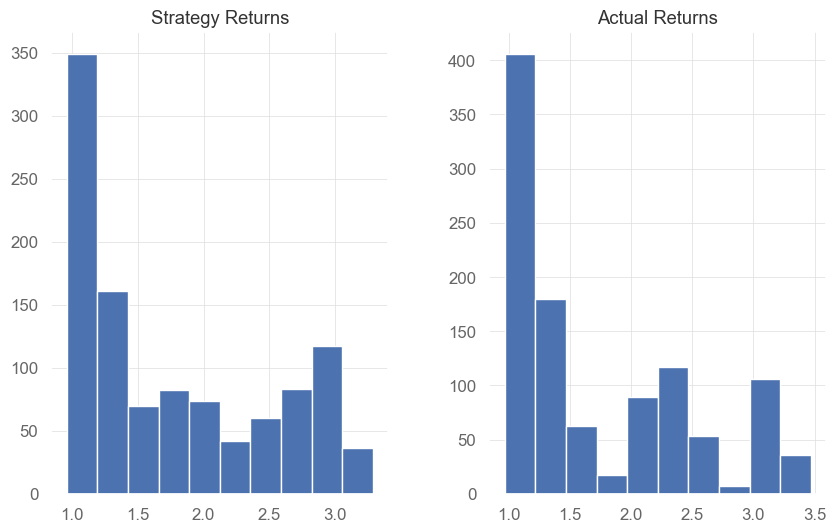

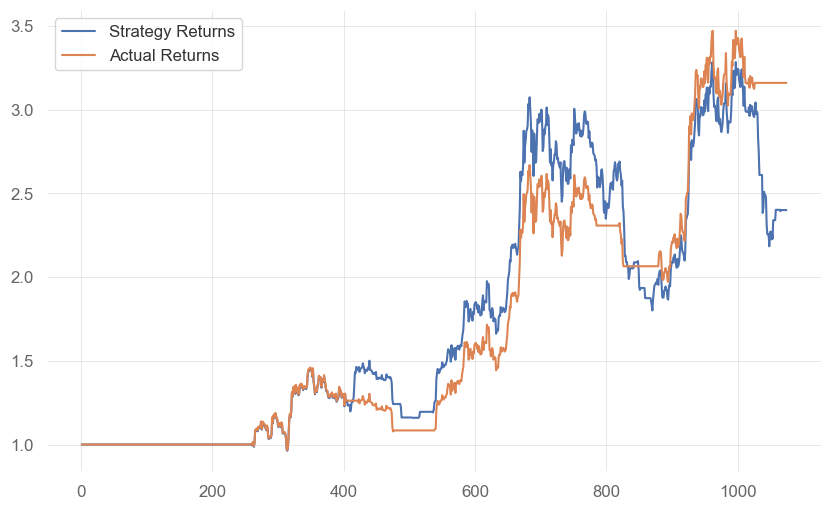

In [25]:
# backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
# backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

backtestdata[['Strategy Returns','Actual Returns']].cumsum().apply(np.exp).hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().apply(np.exp).plot()